# Music Recommendation System
## Importing Libraries

In [ ]:
!pip install spotipy

In [81]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from collections import defaultdict
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist
import difflib

import warnings
warnings.filterwarnings("ignore")

## Wrangling Data
### Gathering Data

In [60]:
data = pd.read_csv("data.csv")
genre_data = pd.read_csv('data_by_genres.csv')
year_data = pd.read_csv('data_by_year.csv')

### Cleaning & Assesing Data

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   id                170653 non-null  object 
 9   instrumentalness  170653 non-null  float64
 10  key               170653 non-null  int64  
 11  liveness          170653 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              170653 non-null  int64  
 14  name              170653 non-null  object 
 15  popularity        170653 non-null  int64  
 16  release_date      17

In [62]:
data.duplicated().sum()

0

In [63]:
genre_data.duplicated().sum()

0

In [64]:
year_data.duplicated().sum()

0

In [65]:
year_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mode              100 non-null    int64  
 1   year              100 non-null    int64  
 2   acousticness      100 non-null    float64
 3   danceability      100 non-null    float64
 4   duration_ms       100 non-null    float64
 5   energy            100 non-null    float64
 6   instrumentalness  100 non-null    float64
 7   liveness          100 non-null    float64
 8   loudness          100 non-null    float64
 9   speechiness       100 non-null    float64
 10  tempo             100 non-null    float64
 11  valence           100 non-null    float64
 12  popularity        100 non-null    float64
 13  key               100 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 11.1 KB


In [66]:
genre_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2973 entries, 0 to 2972
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mode              2973 non-null   int64  
 1   genres            2973 non-null   object 
 2   acousticness      2973 non-null   float64
 3   danceability      2973 non-null   float64
 4   duration_ms       2973 non-null   float64
 5   energy            2973 non-null   float64
 6   instrumentalness  2973 non-null   float64
 7   liveness          2973 non-null   float64
 8   loudness          2973 non-null   float64
 9   speechiness       2973 non-null   float64
 10  tempo             2973 non-null   float64
 11  valence           2973 non-null   float64
 12  popularity        2973 non-null   float64
 13  key               2973 non-null   int64  
dtypes: float64(11), int64(2), object(1)
memory usage: 325.3+ KB


## Data Preprocessing
Clustering data upon its genre

In [67]:
# Create a pipeline and fit it in one go
cluster_pipeline = make_pipeline(StandardScaler(), KMeans(n_clusters=10))
genre_data['cluster'] = cluster_pipeline.fit_predict(genre_data.select_dtypes(include=[np.number]))

In [68]:
tsne_pipeline = make_pipeline(StandardScaler(), TSNE(n_components=2, verbose=1, random_state=42))
projection = pd.DataFrame(tsne_pipeline.fit_transform(genre_data.select_dtypes(include=[np.number])),
                          columns=['x', 'y'])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2973 samples in 0.018s...
[t-SNE] Computed neighbors for 2973 samples in 0.612s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2973
[t-SNE] Computed conditional probabilities for sample 2000 / 2973
[t-SNE] Computed conditional probabilities for sample 2973 / 2973
[t-SNE] Mean sigma: 0.802683
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.487198
[t-SNE] KL divergence after 1000 iterations: 1.200861


In [69]:
projection['genres'] = genre_data['genres']
projection['cluster'] = genre_data['cluster']

<Axes: xlabel='x', ylabel='y'>

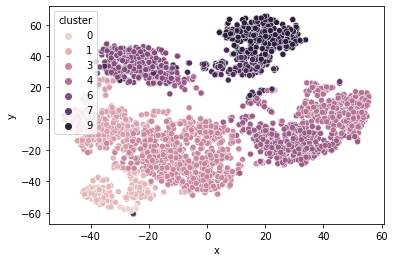

In [70]:
sns.scatterplot(data=projection, x="x", y='y', hue="cluster")

Cluster each song upon its values

In [73]:
song_cluster_pipeline = Pipeline([('scaler', StandardScaler()),
                                  ('kmeans', KMeans(n_clusters=20,
                                   verbose=False))
                                 ], verbose=False)

X = data.select_dtypes(np.number)
number_cols = list(X.columns)
song_cluster_pipeline.fit(X)
song_cluster_labels = song_cluster_pipeline.predict(X)
data['cluster_label'] = song_cluster_labels

In [75]:
pca_pipeline = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=2))])
song_embedding = pca_pipeline.fit_transform(X)
projection = pd.DataFrame(columns=['x', 'y'], data=song_embedding)
projection['title'] = data['name']
projection['cluster'] = data['cluster_label']

<Axes: xlabel='x', ylabel='y'>

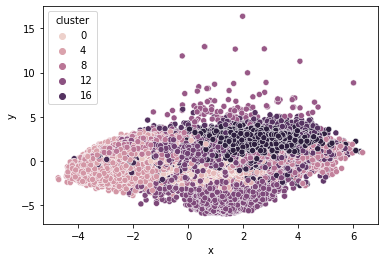

In [77]:
sns.scatterplot(data=projection, x="x", y='y', hue='cluster')

## ML Technique Building
**Another way to search for a song if it's missing in our dataset**

In [79]:
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id='086ce9273ec149168816ac82214269e1',
                                                           client_secret='6ffa5cc37b944f63a28b820b5f7044ef'))

In [80]:
def find_song(name, year):
    song_data = defaultdict()
    results = sp.search(q= 'track: {} year: {}'.format(name,year), limit=1)
    if results['tracks']['items'] == []:
        return None

    results = results['tracks']['items'][0]
    track_id = results['id']
    audio_features = sp.audio_features(track_id)[0]

    song_data['name'] = [name]
    song_data['year'] = [year]
    song_data['explicit'] = [int(results['explicit'])]
    song_data['duration_ms'] = [results['duration_ms']]
    song_data['popularity'] = [results['popularity']]

    for key, value in audio_features.items():
        song_data[key] = value

    return pd.DataFrame(song_data)

Find the song either in our dataset or using **spotify API**

In [82]:
number_cols = ['valence', 'year', 'acousticness', 'danceability', 'duration_ms', 'energy', 'explicit',
 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity', 'speechiness', 'tempo']

def get_song_data(song, spotify_data):

    try:
        song_data = spotify_data[(spotify_data['name'] == song['name'])
                                & (spotify_data['year'] == song['year'])].iloc[0]
        return song_data

    except IndexError:
        return find_song(song['name'], song['year'])

Get input songs center to find its cluster

In [83]:
def get_mean_vector(song_list, spotify_data):

    song_vectors = []

    for song in song_list:
        song_data = get_song_data(song, spotify_data)
        if song_data is None:
            print('Warning: {} does not exist in Spotify or in database'.format(song['name']))
            continue
        song_vector = song_data[number_cols].values
        song_vectors.append(song_vector)

    song_matrix = np.array(list(song_vectors))
    return np.mean(song_matrix, axis=0)

Transform input songs dictionary into list

In [86]:
def flatten_dict_list(dict_list):

    flattened_dict = defaultdict()
    for key in dict_list[0].keys():
        flattened_dict[key] = []

    for dictionary in dict_list:
        for key, value in dictionary.items():
            flattened_dict[key].append(value)

    return flattened_dict

Main function that takes most repeated songs and recommend songs

In [94]:
def recommend_songs(song_list, spotify_data = data, n_songs=5):

    metadata_cols = ['name', 'year', 'artists']
    song_dict = flatten_dict_list(song_list)

    song_center = get_mean_vector(song_list, spotify_data)
    scaler = song_cluster_pipeline.steps[0][1]
    scaled_data = scaler.transform(spotify_data[number_cols])
    scaled_song_center = scaler.transform(song_center.reshape(1, -1))
    distances = cdist(scaled_song_center, scaled_data, 'cosine')
    index = list(np.argsort(distances)[:, :n_songs][0])

    rec_songs = spotify_data.iloc[index]
    rec_songs = rec_songs[~rec_songs['name'].isin(song_dict['name'])]
    return rec_songs[metadata_cols].to_dict(orient='records')

## Example

In [99]:
recommend_songs([{"name": 'bad guy', 'year':2019}])

[{'name': 'Gold', 'year': 2016, 'artists': "['Kiiara']"},
 {'name': "A Winter's Ball",
  'year': 2015,
  'artists': "['Leslie Odom Jr.', 'Lin-Manuel Miranda', 'Original Broadway Cast of Hamilton']"},
 {'name': 'Guns and Ships',
  'year': 2015,
  'artists': "['Leslie Odom Jr.', 'Daveed Diggs', 'Original Broadway Cast of Hamilton']"},
 {'name': 'Your Obedient Servant',
  'year': 2015,
  'artists': "['Leslie Odom Jr.', 'Lin-Manuel Miranda', 'Original Broadway Cast of Hamilton']"}]